<a href="https://colab.research.google.com/github/marcelinorahul/registlombawebsite/blob/main/S_BERT_KELUHAN_SENTYMEN_GOJEK_PENELITIAN_147_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install library yang diperlukan
!pip install transformers datasets torch scikit-learn pandas matplotlib seaborn -q

print("Instalasi selesai")

Instalasi selesai


01. mengimport modul py

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Library berhasil di-import")
print(f"GPU tersedia: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Library berhasil di-import
GPU tersedia: True
GPU Name: Tesla T4


02. import data gojek.csv

In [ ]:
from google.colab import files

# Upload file CSV
uploaded = files.upload()

# Ambil nama file
file_name = list(uploaded.keys())[0]
print(f"\nFile berhasil di-upload: {file_name}")

# Load dataset
df = pd.read_csv(file_name)

# Strip whitespace dari nama kolom
df.columns = df.columns.str.strip()

print(f"\nTotal data: {len(df)}")
print(f"\nKolom asli: {df.columns.tolist()}")

# Rename kolom sesuai kebutuhan
# score -> rating, content -> review
df = df.rename(columns={
    'score': 'rating',
    'content': 'review'
})

print(f"\nKolom setelah rename: {df.columns.tolist()}")
print(f"\nSample 3 baris:")
print(df[['rating', 'review']].head(3))

# Cek apakah ada data kosong
print(f"\nMissing values:")
print(df[['rating', 'review']].isnull().sum())

# Drop rows dengan review atau rating kosong
df = df.dropna(subset=['rating', 'review']).reset_index(drop=True)

print(f"\nTotal data setelah drop missing: {len(df)}")
print("\n✓ Dataset siap diproses!")

Saving gojek.csv to gojek.csv

File berhasil di-upload: gojek.csv

Total data: 116017

Kolom asli: ['id', 'created_at', 'score', 'content', 'thumbsUpCount']

Kolom setelah rename: ['id', 'created_at', 'rating', 'review', 'thumbsUpCount']

Sample 3 baris:
   rating                                             review
0       1  Gojek udah ga kayak dlu. Skrg ongkirnya mahal....
1       2  Setelah update jadi ngelag dan banyak bug. Say...
2       2  Tolong untuk Go Food, bagian terdekat, enak ya...

Missing values:
rating    0
review    1
dtype: int64

Total data setelah drop missing: 116016

✓ Dataset siap diproses!


03. cek pembagian data

Distribusi Rating:
rating
1    46612
2    10046
3    10027
4     8324
5    41007
Name: count, dtype: int64


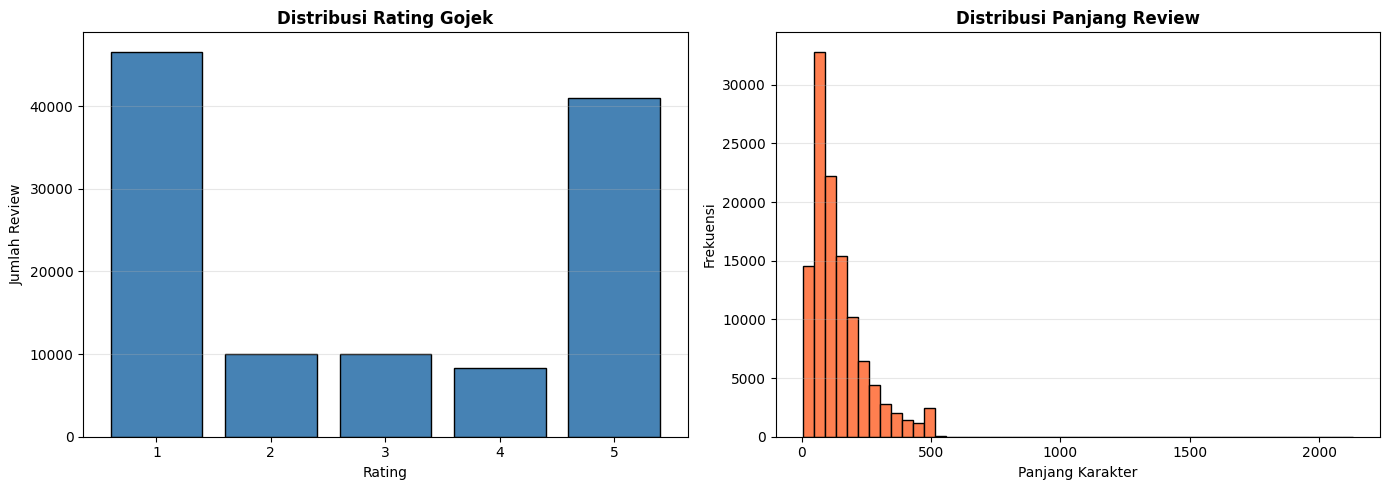


Statistik panjang review:
count    116016.000000
mean        141.253172
std         106.347362
min           6.000000
25%          65.000000
50%         109.000000
75%         183.000000
max        2129.000000
Name: review_length, dtype: float64

Missing values:
id               0
created_at       0
rating           0
review           0
thumbsUpCount    0
review_length    0
dtype: int64

Total data setelah cleaning: 116016


In [ ]:
# Cek distribusi rating
print("Distribusi Rating:")
rating_dist = df['rating'].value_counts().sort_index()
print(rating_dist)

# Visualisasi distribusi rating
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart rating
axes[0].bar(rating_dist.index, rating_dist.values, color='steelblue', edgecolor='black')
axes[0].set_title('Distribusi Rating Gojek', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Jumlah Review')
axes[0].grid(axis='y', alpha=0.3)

# Statistik panjang review
df['review_length'] = df['review'].astype(str).str.len()
axes[1].hist(df['review_length'], bins=50, color='coral', edgecolor='black')
axes[1].set_title('Distribusi Panjang Review', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Panjang Karakter')
axes[1].set_ylabel('Frekuensi')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nStatistik panjang review:")
print(df['review_length'].describe())

# Cek missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# Drop rows dengan review kosong
df = df[df['review'].notna()].reset_index(drop=True)
print(f"\nTotal data setelah cleaning: {len(df)}")

04. preprosesing :

In [ ]:
from tqdm import tqdm
tqdm.pandas()

# Fungsi preprocessing untuk membersihkan teks
def preprocess_text(text):
    # Konversi ke string dan lowercase
    text = str(text).lower()

    # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Hapus mention dan hashtag
    text = re.sub(r'@\w+|#\w+', '', text)

    # Hapus email
    text = re.sub(r'\S+@\S+', '', text)

    # Dictionary normalisasi slang Indonesia
    slang_dict = {
        r'\bga\b': 'tidak', r'\bgak\b': 'tidak', r'\btdk\b': 'tidak',
        r'\budh\b': 'sudah', r'\budah\b': 'sudah',
        r'\bcm\b': 'cuma', r'\byg\b': 'yang',
        r'\bkrn\b': 'karena', r'\bdr\b': 'dari',
        r'\baja\b': 'saja', r'\bdg\b': 'dengan',
        r'\btlg\b': 'tolong', r'\btq\b': 'terima kasih',
        r'\btks\b': 'terima kasih', r'\bbanget\b': 'sangat',
        r'\bbgt\b': 'sangat', r'\bjg\b': 'juga',
        r'\bknp\b': 'kenapa', r'\bknapa\b': 'kenapa',
        r'\btrus\b': 'terus', r'\bgmn\b': 'bagaimana',
        r'\bgimana\b': 'bagaimana', r'\bjd\b': 'jadi',
        r'\bgpp\b': 'tidak apa apa', r'\bgmana\b': 'bagaimana',
        r'\btp\b': 'tetapi', r'\btpi\b': 'tetapi',
        r'\borg\b': 'orang', r'\bklo\b': 'kalau',
        r'\bkl\b': 'kalau', r'\bsy\b': 'saya',
        r'\bgw\b': 'saya', r'\blu\b': 'kamu'
    }

    # Terapkan normalisasi
    for slang, formal in slang_dict.items():
        text = re.sub(slang, formal, text, flags=re.IGNORECASE)

    # Hapus karakter non-alfabet kecuali spasi
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Hapus spasi berlebih
    text = ' '.join(text.split())

    return text

# Terapkan preprocessing dengan progress bar
print("Memproses teks (sabar sayang e)...")
df['review_clean'] = df['review'].progress_apply(preprocess_text)

print("\nContoh hasil preprocessing:")
for i in range(3):
    print(f"\n--- Sample {i+1} ---")
    print(f"Original: {df['review'].iloc[i][:150]}")
    print(f"Cleaned:  {df['review_clean'].iloc[i][:150]}")

Memproses teks (sabar sayang e)...


100%|██████████| 116016/116016 [00:15<00:00, 7679.71it/s] 


Contoh hasil preprocessing:

--- Sample 1 ---
Original: Gojek udah ga kayak dlu. Skrg ongkirnya mahal. Ongkir gofood untuk jarak 1 -2km kayak ongkir untuk jarak 7-10km. Trus ditambah ada biaya layanan juga.
Cleaned:  gojek sudah tidak kayak dlu skrg ongkirnya mahal ongkir gofood untuk jarak km kayak ongkir untuk jarak km terus ditambah ada biaya layanan juga kalo p

--- Sample 2 ---
Original: Setelah update jadi ngelag dan banyak bug. Saya tidak bisa menambah alamat baru, setelah di set tidak ada respon dari aplikasi. Saat pesan makanan jug
Cleaned:  setelah update jadi ngelag dan banyak bug saya tidak bisa menambah alamat baru setelah di set tidak ada respon dari aplikasi saat pesan makanan juga j

--- Sample 3 ---
Original: Tolong untuk Go Food, bagian terdekat, enak yang dulu, pakai jarak, jadi bisa tahu resto/makanan terdekat sama jarak nya, kalau yang sekarang pakai 30
Cleaned:  tolong untuk go food bagian terdekat enak yang dulu pakai jarak jadi bisa tahu resto makanan terdekat 

05. ubah rating jadi sentymen

Distribusi Sentiment:
sentiment
Negative    56658
Positive    49331
Neutral     10027
Name: count, dtype: int64


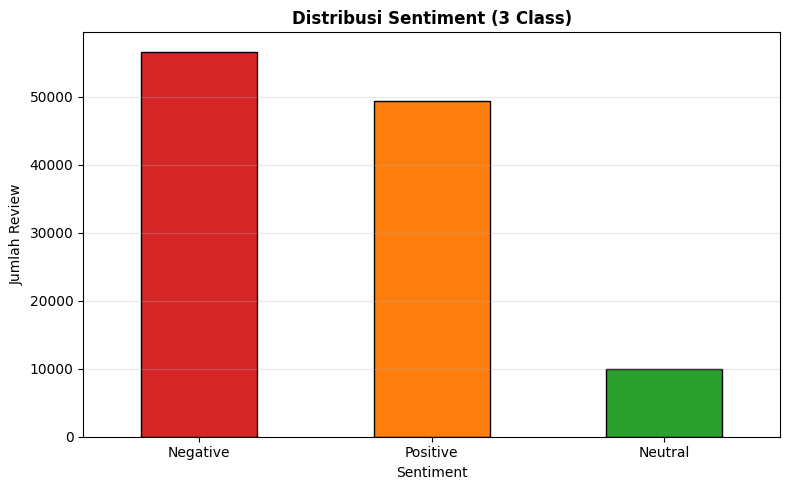


Persentase per kelas:
Negative: 56658 (48.8%)
Positive: 49331 (42.5%)
Neutral: 10027 (8.6%)


In [ ]:
# Konversi rating ke sentiment 3 class
def rating_to_sentiment(rating):
    if rating >= 4:
        return 2  # Positive
    elif rating == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

df['label'] = df['rating'].apply(rating_to_sentiment)

# Mapping label ke nama
label_names = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
df['sentiment'] = df['label'].map(label_names)

# Cek distribusi label
print("Distribusi Sentiment:")
sentiment_dist = df['sentiment'].value_counts()
print(sentiment_dist)

# Visualisasi distribusi sentiment
plt.figure(figsize=(8, 5))
colors = ['#d62728', '#ff7f0e', '#2ca02c']
sentiment_dist.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Distribusi Sentiment (3 Class)', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Jumlah Review')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Cek persentase
print("\nPersentase per kelas:")
for sentiment, count in sentiment_dist.items():
    pct = (count / len(df)) * 100
    print(f"{sentiment}: {count} ({pct:.1f}%)")

06. buat dataset pytorch

In [ ]:
# Class untuk membuat dataset PyTorch
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]

        # Tokenize teks dengan BERT tokenizer
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

print("Dataset class berhasil didefinisikan")

Dataset class berhasil didefinisikan


07. split data 70 10 20:

In [ ]:
# Split data dengan stratifikasi
# 70% train, 10% validation, 20% test

# Split pertama: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    df['review_clean'],
    df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=SEED
)

# Split kedua: dari 80% ambil 87.5% untuk train (70% total) dan 12.5% untuk val (10% total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.125,
    stratify=y_temp,
    random_state=SEED
)

print(f"Data Training: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"Data Validation: {len(X_val)} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"Data Testing: {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)")

# Cek distribusi label di setiap split
print("\nDistribusi Training:")
print(y_train.value_counts().sort_index())
print("\nDistribusi Validation:")
print(y_val.value_counts().sort_index())
print("\nDistribusi Testing:")
print(y_test.value_counts().sort_index())

Data Training: 81210 samples (70.0%)
Data Validation: 11602 samples (10.0%)
Data Testing: 23204 samples (20.0%)

Distribusi Training:
label
0    39660
1     7019
2    34531
Name: count, dtype: int64

Distribusi Validation:
label
0    5666
1    1003
2    4933
Name: count, dtype: int64

Distribusi Testing:
label
0    11332
1     2005
2     9867
Name: count, dtype: int64


08. load indobert tokenizer untuk buat dataloader :

In [ ]:
# Load IndoBERT tokenizer - model terbaik untuk bahasa Indonesia
MODEL_NAME = 'indolem/indobert-base-uncased'
print(f"Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Buat dataset untuk train, validation, dan test
MAX_LENGTH = 256
train_dataset = ReviewDataset(X_train, y_train, tokenizer, max_length=MAX_LENGTH)
val_dataset = ReviewDataset(X_val, y_val, tokenizer, max_length=MAX_LENGTH)
test_dataset = ReviewDataset(X_test, y_test, tokenizer, max_length=MAX_LENGTH)

# Buat DataLoader
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoader berhasil dibuat:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Test satu batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch shape:")
print(f"Input IDs: {sample_batch['input_ids'].shape}")
print(f"Attention Mask: {sample_batch['attention_mask'].shape}")
print(f"Labels: {sample_batch['label'].shape}")

Loading tokenizer: indolem/indobert-base-uncased


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


DataLoader berhasil dibuat:
Train batches: 5076
Val batches: 726
Test batches: 1451

Sample batch shape:
Input IDs: torch.Size([16, 256])
Attention Mask: torch.Size([16, 256])
Labels: torch.Size([16])


9. SBERT dengan mean poling untuk klasifikasi sentimen

In [ ]:
# Model Sentence-BERT dengan Mean Pooling untuk klasifikasi sentiment
class SentenceBERTClassifier(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.3):
        super(SentenceBERTClassifier, self).__init__()

        # Load pretrained IndoBERT
        self.bert = AutoModel.from_pretrained(MODEL_NAME)

        # Dropout untuk regularisasi
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected layer untuk klasifikasi
        self.classifier = nn.Linear(768, num_classes)

    def mean_pooling(self, token_embeddings, attention_mask):
        # Mean pooling: rata-rata semua token embeddings dengan memperhatikan mask
        # Ini menghasilkan sentence-level representation yang lebih baik dari CLS token
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, input_ids, attention_mask):
        # Forward pass melalui BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Ambil hidden states terakhir dari semua token
        token_embeddings = outputs.last_hidden_state

        # Apply mean pooling untuk mendapat sentence embedding
        sentence_embedding = self.mean_pooling(token_embeddings, attention_mask)

        # Apply dropout
        pooled_output = self.dropout(sentence_embedding)

        # Klasifikasi
        logits = self.classifier(pooled_output)

        return logits

print("Model Sentence-BERT berhasil didefinisikan")

Model Sentence-BERT berhasil didefinisikan


10. setup device utk training

In [ ]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = SentenceBERTClassifier(num_classes=3, dropout_rate=0.3)
model = model.to(device)

# Hitung jumlah parameter
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer dengan weight decay untuk regularisasi
LEARNING_RATE = 2e-5
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# Learning rate scheduler dengan warmup
EPOCHS = 2
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"\nTraining configuration:")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")

Using device: cuda


pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]


Total parameters: 110,560,515
Trainable parameters: 110,560,515

Training configuration:
Epochs: 4
Batch size: 16
Learning rate: 2e-05
Total training steps: 20304
Warmup steps: 2030


11. training 1 epoch :

In [ ]:
# Fungsi untuk training satu epoch
def train_epoch(model, data_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping untuk mencegah exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        # Hitung akurasi batch
        preds = torch.argmax(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels).item()
        total_samples += labels.size(0)
        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

# Fungsi untuk evaluasi
def eval_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            # Hitung akurasi batch
            preds = torch.argmax(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
            total_samples += labels.size(0)
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

print("Training functions berhasil didefinisikan")

Training functions berhasil didefinisikan


12. training model epoch 1:

In [ ]:
# Training loop dengan tracking metrics
print("="*70)
print("MEMULAI TRAINING")
print("="*70)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_loss = float('inf')
best_model_state = None

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 70)

    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    val_loss, val_acc = eval_model(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    # Save best model berdasarkan validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        print(">>> Best model saved!")

# Load best model untuk testing
model.load_state_dict(best_model_state)
print("\n" + "="*70)
print("TRAINING SELESAI! Model terbaik berhasil di-load.")
print("="*70)

MEMULAI TRAINING

Epoch 1/4
----------------------------------------------------------------------
Train Loss: 0.5751 | Train Acc: 0.7844
Val Loss:   0.4998 | Val Acc:   0.8230
>>> Best model saved!

Epoch 2/4
----------------------------------------------------------------------
Train Loss: 0.4810 | Train Acc: 0.8261
Val Loss:   0.4827 | Val Acc:   0.8305
>>> Best model saved!

Epoch 3/4
----------------------------------------------------------------------


KeyboardInterrupt: 

13. visualisasi hasil training :

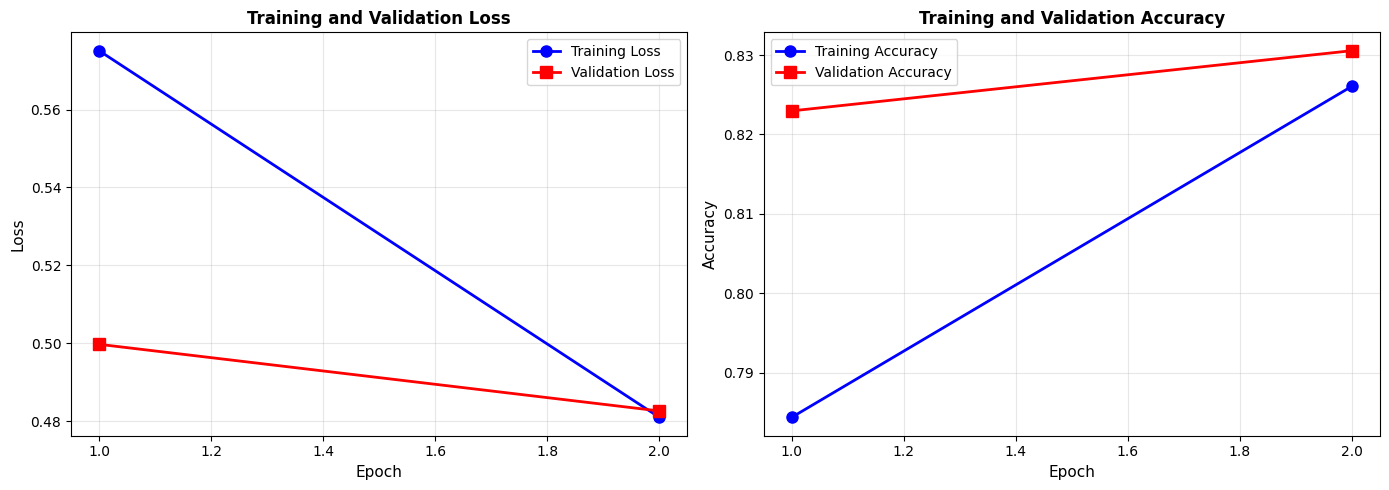

Best validation loss: 0.4827
Best validation accuracy: 0.8305


In [ ]:
# Visualisasi training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, min(len(train_losses), len(val_losses)) + 1)

# Plot loss
ax1.plot(epochs_range, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=8)
ax1.plot(epochs_range, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(epochs_range, train_accuracies, 'b-o', label='Training Accuracy', linewidth=2, markersize=8)
ax2.plot(epochs_range, val_accuracies, 'r-s', label='Validation Accuracy', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Accuracy', fontsize=11)
ax2.set_title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {max(val_accuracies):.4f}")

14. fungsi prediksi label yang betul

In [ ]:
# Fungsi untuk mendapatkan prediksi dan true labels
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

# Dapatkan prediksi pada test set
print("Mendapatkan prediksi pada test set...")
y_pred, y_true = get_predictions(model, test_loader, device)
print(f"Prediksi selesai! Total test samples: {len(y_true)}")

Mendapatkan prediksi pada test set...
Prediksi selesai! Total test samples: 23204


15. training proses plot akurasi

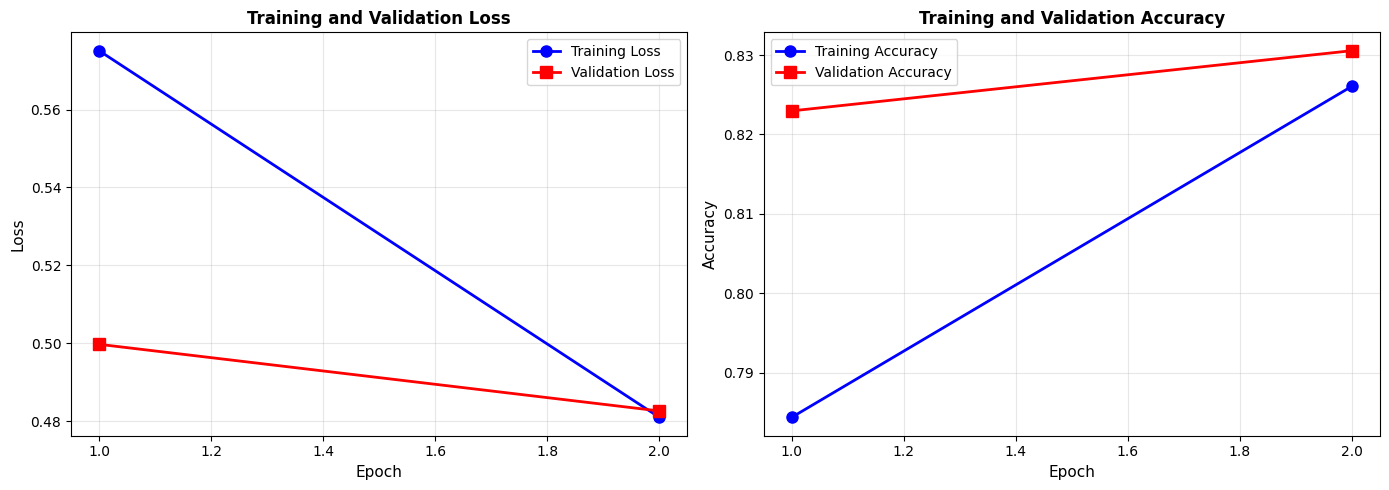

Best validation loss: 0.4827
Best validation accuracy: 0.8305


In [ ]:
# Visualisasi training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, min(len(train_losses), len(val_losses), len(train_accuracies), len(val_accuracies)) + 1)

# Plot loss
ax1.plot(epochs_range, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=8)
ax1.plot(epochs_range, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(epochs_range, train_accuracies, 'b-o', label='Training Accuracy', linewidth=2, markersize=8)
ax2.plot(epochs_range, val_accuracies, 'r-s', label='Validation Accuracy', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Accuracy', fontsize=11)
ax2.set_title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {max(val_accuracies):.4f}")

16. buat laporan lengkap klasifikasi sentimen

In [ ]:
# Generate classification report lengkap
target_names = ['Negative', 'Neutral', 'Positive']
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)

print("\n" + "="*70)
print("CLASSIFICATION REPORT - SENTENCE-BERT")
print("="*70)
print(report)

# Hitung metrics tambahan
overall_accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)

print(f"\nWeighted Metrics:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  Accuracy: {overall_accuracy:.4f}")


CLASSIFICATION REPORT - SENTENCE-BERT
              precision    recall  f1-score   support

    Negative     0.7900    0.9431    0.8598     11332
     Neutral     0.2724    0.0668    0.1073      2005
    Positive     0.8994    0.8371    0.8671      9867

    accuracy                         0.8223     23204
   macro avg     0.6539    0.6157    0.6114     23204
weighted avg     0.7918    0.8223    0.7979     23204


Weighted Metrics:
  Precision: 0.7918
  Recall: 0.8223
  F1-Score: 0.7979
  Accuracy: 0.8223


17. perbandingan model tf idf + logistic regresion

In [ ]:
# Baseline: TF-IDF + Logistic Regression
print("\n" + "="*70)
print("TRAINING BASELINE MODEL")
print("="*70)

# Vectorize dengan TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced')
lr_model.fit(X_train_tfidf, y_train)

# Prediksi
y_pred_baseline = lr_model.predict(X_test_tfidf)

# Evaluasi baseline
print("\n" + "="*70)
print("CLASSIFICATION REPORT - BASELINE (TF-IDF + LR)")
print("="*70)
baseline_report = classification_report(y_true, y_pred_baseline, target_names=target_names, digits=4)
print(baseline_report)

baseline_accuracy = accuracy_score(y_true, y_pred_baseline)
precision_bl, recall_bl, f1_bl, _ = precision_recall_fscore_support(
    y_true, y_pred_baseline, average='weighted', zero_division=0
)

print(f"\nBaseline Weighted Metrics:")
print(f"  Precision: {precision_bl:.4f}")
print(f"  Recall: {recall_bl:.4f}")
print(f"  F1-Score: {f1_bl:.4f}")
print(f"  Accuracy: {baseline_accuracy:.4f}")


TRAINING BASELINE MODEL

CLASSIFICATION REPORT - BASELINE (TF-IDF + LR)
              precision    recall  f1-score   support

    Negative     0.8321    0.7030    0.7621     11332
     Neutral     0.1788    0.4743    0.2597      2005
    Positive     0.9030    0.7607    0.8258      9867

    accuracy                         0.7078     23204
   macro avg     0.6380    0.6460    0.6159     23204
weighted avg     0.8058    0.7078    0.7458     23204


Baseline Weighted Metrics:
  Precision: 0.8058
  Recall: 0.7078
  F1-Score: 0.7458
  Accuracy: 0.7078


18. Tabel hasil banding model


MODEL COMPARISON
                       Model  Precision   Recall  F1-Score  Accuracy
TF-IDF + Logistic Regression   0.805827 0.707766  0.745777  0.707766
    Sentence-BERT (IndoBERT)   0.791783 0.822315  0.797892  0.822315


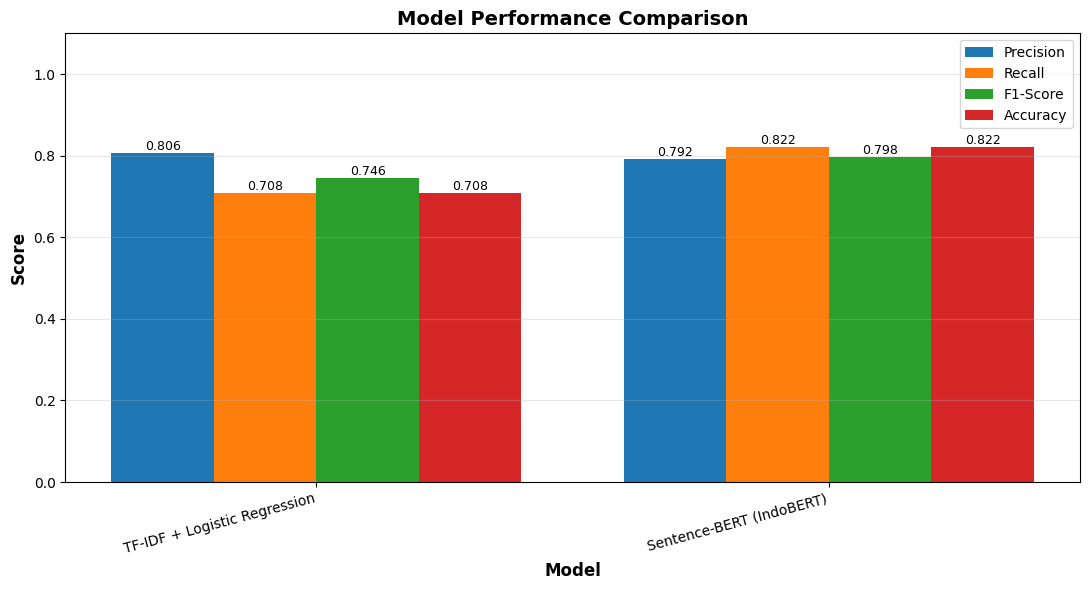


Sentence-BERT improvement over baseline: 16.18%


In [ ]:
# Tabel perbandingan model
comparison_df = pd.DataFrame({
    'Model': ['TF-IDF + Logistic Regression', 'Sentence-BERT (IndoBERT)'],
    'Precision': [precision_bl, precision],
    'Recall': [recall_bl, recall],
    'F1-Score': [f1_bl, f1],
    'Accuracy': [baseline_accuracy, overall_accuracy]
})

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))

# Visualisasi perbandingan
fig, ax = plt.subplots(figsize=(11, 6))
x = np.arange(len(comparison_df['Model']))
width = 0.2

metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, metric in enumerate(metrics):
    values = comparison_df[metric].values
    bars = ax.bar(x + i*width, values, width, label=metric, color=colors[i])

    # Tambahkan nilai di atas bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend(fontsize=10)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Hitung improvement
improvement = ((overall_accuracy - baseline_accuracy) / baseline_accuracy) * 100
print(f"\nSentence-BERT improvement over baseline: {improvement:.2f}%")

19. Tes fungsi untuk prediksi teks yang baru

In [ ]:
# Fungsi untuk prediksi text baru
def predict_sentiment(text, model, tokenizer, device, label_names):
    model.eval()

    # Preprocessing
    text_clean = preprocess_text(text)

    # Tokenize
    encoding = tokenizer(
        text_clean,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Prediksi
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_label].item()

    sentiment = label_names[pred_label]

    return sentiment, confidence, probs[0].cpu().numpy()

# Test prediksi dengan contoh review
test_reviews = [
    "Aplikasi sering crash dan lemot banget. Sangat mengecewakan!",
    "Lumayan sih, tapi masih ada bug di fitur gopay",
    "Sangat puas dengan layanan gojek. Driver ramah dan cepat!",
    "Ga bisa login, password reset juga ga berfungsi",
    "Ok lah, standar aja mungkin baikin dikit ui ux nya"
]

print("\n" + "="*70)
print("CONTOH PREDIKSI SENTIMENT")
print("="*70)

for i, review in enumerate(test_reviews):
    sentiment, confidence, probs = predict_sentiment(review, model, tokenizer, device, label_names)
    print(f"\nReview {i+1}: {review}")
    print(f"Predicted Sentiment: {sentiment}")
    print(f"Confidence: {confidence:.4f}")
    print(f"Probabilities - Negative: {probs[0]:.4f}, Neutral: {probs[1]:.4f}, Positive: {probs[2]:.4f}")


CONTOH PREDIKSI SENTIMENT

Review 1: Aplikasi sering crash dan lemot banget. Sangat mengecewakan!
Predicted Sentiment: Negative
Confidence: 0.9733
Probabilities - Negative: 0.9733, Neutral: 0.0162, Positive: 0.0105

Review 2: Lumayan sih, tapi masih ada bug di fitur gopay
Predicted Sentiment: Positive
Confidence: 0.9057
Probabilities - Negative: 0.0087, Neutral: 0.0856, Positive: 0.9057

Review 3: Sangat puas dengan layanan gojek. Driver ramah dan cepat!
Predicted Sentiment: Positive
Confidence: 0.9977
Probabilities - Negative: 0.0010, Neutral: 0.0013, Positive: 0.9977

Review 4: Ga bisa login, password reset juga ga berfungsi
Predicted Sentiment: Negative
Confidence: 0.9211
Probabilities - Negative: 0.9211, Neutral: 0.0429, Positive: 0.0360

Review 5: Ok lah, standar aja mungkin baikin dikit ui ux nya
Predicted Sentiment: Positive
Confidence: 0.9966
Probabilities - Negative: 0.0011, Neutral: 0.0022, Positive: 0.9966


20. simpan model training

In [ ]:
# Save trained model dan tokenizer
import os

# Buat direktori untuk menyimpan model
save_dir = 'sentiment_model'
os.makedirs(save_dir, exist_ok=True)

# Save model state
model_save_path = os.path.join(save_dir, 'model.pth')
torch.save({
    'model_state_dict': model.state_dict(),
    'label_names': label_names,
    'model_name': MODEL_NAME,
    'vocab_size': tokenizer.vocab_size,
    'max_length': MAX_LENGTH,
    'num_classes': 3
}, model_save_path)

print(f"Model berhasil disimpan di: {model_save_path}")

# Save tokenizer
tokenizer.save_pretrained(save_dir)
print(f"Tokenizer berhasil disimpan di: {save_dir}")

# Zip folder untuk download
!zip -r sentiment_model.zip {save_dir}

# Download model
files.download('sentiment_model.zip')
print("\nModel dan tokenizer berhasil di-download!")

Model berhasil disimpan di: sentiment_model/model.pth
Tokenizer berhasil disimpan di: sentiment_model
updating: sentiment_model/ (stored 0%)
updating: sentiment_model/tokenizer.json (deflated 71%)
updating: sentiment_model/tokenizer_config.json (deflated 74%)
updating: sentiment_model/model.pth

 (deflated 7%)
updating: sentiment_model/special_tokens_map.json (deflated 42%)
updating: sentiment_model/vocab.txt (deflated 52%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Model dan tokenizer berhasil di-download!


21. hasil keseluruhan tahapan penelitian

In [ ]:
# Ringkasan hasil eksperimen
print("\n" + "="*70)
print("RINGKASAN HASIL EKSPERIMEN")
print("="*70)

print(f"\nDataset:")
print(f"  Total data: {len(df)}")
print(f"  Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
print(f"  Classes: Negative, Neutral, Positive")

print(f"\nModel:")
print(f"  Architecture: Sentence-BERT dengan Mean Pooling")
print(f"  Base model: {MODEL_NAME}")
print(f"  Total parameters: {total_params:,}")
print(f"  Max sequence length: {MAX_LENGTH}")

print(f"\nTraining:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Best validation loss: {best_val_loss:.4f}")

print(f"\nTest Results (Sentence-BERT):")
print(f"  Accuracy: {overall_accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

print(f"\nBaseline Results (TF-IDF + LR):")
print(f"  Accuracy: {baseline_accuracy:.4f}")
print(f"  Precision: {precision_bl:.4f}")
print(f"  Recall: {recall_bl:.4f}")
print(f"  F1-Score: {f1_bl:.4f}")

print(f"\nImprovement:")
print(f"  Accuracy: +{(overall_accuracy - baseline_accuracy):.4f} ({improvement:.2f}%)")
print(f"  F1-Score: +{(f1 - f1_bl):.4f}")

print("\n" + "="*70)


RINGKASAN HASIL EKSPERIMEN

Dataset:
  Total data: 116016
  Train: 81210 | Val: 11602 | Test: 23204
  Classes: Negative, Neutral, Positive

Model:
  Architecture: Sentence-BERT dengan Mean Pooling
  Base model: indolem/indobert-base-uncased
  Total parameters: 110,560,515
  Max sequence length: 256

Training:
  Epochs: 4
  Batch size: 16
  Learning rate: 2e-05
  Best validation loss: 0.4827

Test Results (Sentence-BERT):
  Accuracy: 0.8223
  Precision: 0.7918
  Recall: 0.8223
  F1-Score: 0.7979

Baseline Results (TF-IDF + LR):
  Accuracy: 0.7078
  Precision: 0.8058
  Recall: 0.7078
  F1-Score: 0.7458

Improvement:
  Accuracy: +0.1145 (16.18%)
  F1-Score: +0.0521



22. analisis kasus yang eror untuk klasifikasi yang susah

In [ ]:
class_names = ["Negative", "Neutral", "Positive"]
# Analisis error untuk memahami kasus yang sulit diklasifikasi
error_indices = np.where(y_pred != y_true)[0]
print(f"\nTotal misclassified samples: {len(error_indices)} out of {len(y_true)} ({len(error_indices)/len(y_true)*100:.2f}%)")

# Analisis error per kelas
print("\nMisclassification per class:")
for i, class_name in enumerate(class_names):
    class_errors = np.sum((y_true == i) & (y_pred != i))
    class_total = np.sum(y_true == i)
    error_rate = (class_errors / class_total * 100) if class_total > 0 else 0
    print(f"  {class_name}: {class_errors}/{class_total} ({error_rate:.1f}%)")

# Tampilkan beberapa contoh misclassification
if len(error_indices) > 0:
    print("\nContoh misclassification (5 pertama):")
    test_texts = X_test.reset_index(drop=True)

    for i, idx in enumerate(error_indices[:5]):
        true_label = label_names[y_true[idx]]
        pred_label = label_names[y_pred[idx]]
        text = test_texts.iloc[idx][:150]

        print(f"\n{i+1}. Review: {text}...")
        print(f"   True: {true_label} | Predicted: {pred_label}")


Total misclassified samples: 4123 out of 23204 (17.77%)

Misclassification per class:
  Negative: 645/11332 (5.7%)
  Neutral: 1871/2005 (93.3%)
  Positive: 1607/9867 (16.3%)

Contoh misclassification (5 pertama):

1. Review: parah versi baru hanya untuk andoid baru bagi hp yang pakai android lama selalu force close suruh update andoid emang nenek moyang lo seenaknya minta ...
   True: Neutral | Predicted: Negative

2. Review: di propinsi jambi penjemputan selalu jauh dan ongkos terlalu murah jadi driver tidak mau narik penumpang kerna tidak sesuai...
   True: Positive | Predicted: Negative

3. Review: saya suka bingun sama penumpang yang ngasih bintang jelek salahnya apah yah waktu jemput pas di jalan sudah hati...
   True: Positive | Predicted: Negative

4. Review: mau login ke gojek aplikasi gk terbuka ini kenapa...
   True: Positive | Predicted: Negative

5. Review: apk sudah bagus tapi tiap pagi susah sangat dapet mobil sekalinya dapet di cancel...
   True: Positive | Predicted: N

23. visualisasi per kelasny masing masing

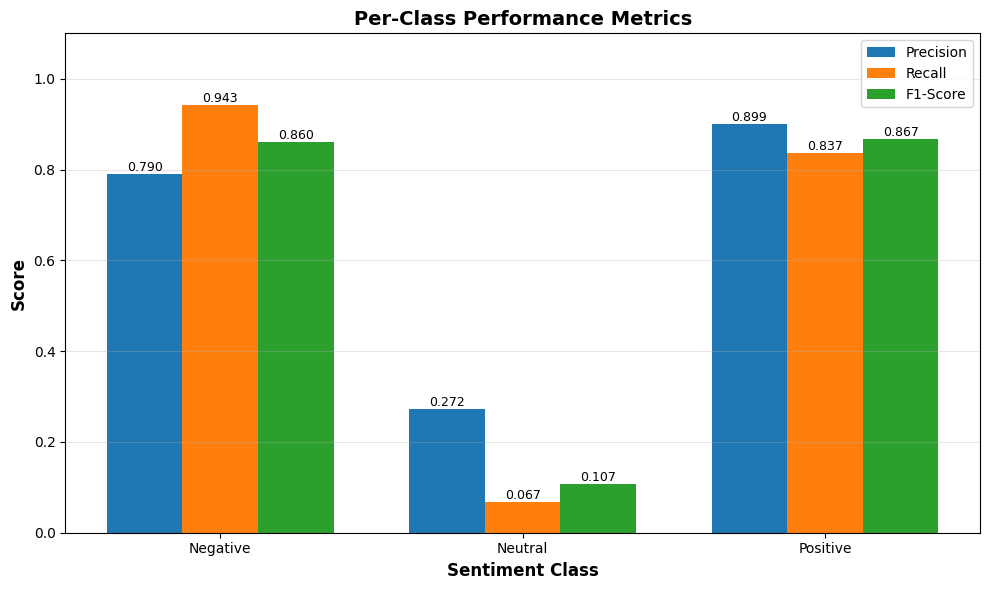


Support (jumlah sample per class di test set):
  Negative: 11332
  Neutral: 2005
  Positive: 9867


In [ ]:
# Visualisasi per-class performance
from sklearn.metrics import precision_recall_fscore_support

precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_true, y_pred, labels=[0, 1, 2], zero_division=0
)

# Buat bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(class_names))
width = 0.25

bars1 = ax.bar(x - width, precision_per_class, width, label='Precision', color='#1f77b4')
bars2 = ax.bar(x, recall_per_class, width, label='Recall', color='#ff7f0e')
bars3 = ax.bar(x + width, f1_per_class, width, label='F1-Score', color='#2ca02c')

# Tambahkan nilai di atas bar
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Sentiment Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend(fontsize=10)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print support
print("\nSupport (jumlah sample per class di test set):")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {support_per_class[i]}")